In [30]:
import pandas as pd 
import numpy as np
import json
import pprint
from scipy import stats
from collections import  Counter
from scipy.stats import entropy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [31]:
data = pd.read_csv('Data/USvideos.csv')
samples = data.sample(n=50)
new_df = pd.DataFrame(samples,columns = ['views', 'comment_count','category_id','trending_date','tags'])

def cleanString(incomingString):
    newstring = incomingString
    newstring = newstring.replace("\"","")
    newstring = list(filter(None,newstring.split('|')))
    return newstring

tagsList = []
tagsList = [ cleanString(col['tags']) for idx,col in new_df.iterrows()] 
new_df['tags'] = tagsList
def normalize(col):
    min = np.min(col)
    max = np.max(col)
    range = max - min

    return [(item - min) / range for item in col]
new_df['views'], new_df['comment_count'] = normalize(new_df['views']), normalize(new_df['comment_count'])
new_df


,views,comment_count,category_id,trending_date,tags
25186,0.083640,0.431407,27,18.22.03,"[life noggin, life noggin youtube, youtube lif..."
24211,0.035363,0.006822,23,18.17.03,[[none]]
31816,0.254785,0.026755,24,18.30.04,"[smallfoot, smallfoot trailer, zendaya, channi..."
7186,0.102053,0.123403,1,17.19.12,"[screenjunkies, screen junkies, honest trailer..."
23017,0.045913,0.035422,10,18.11.03,"[Flower, of, the, Universe, (From, Disney's, W..."
39321,0.131639,0.115603,25,18.06.06,"[The TODAY Show, TODAY Show, TODAY, NBC, NBC N..."
14745,0.051746,0.039699,24,18.28.01,"[documentary, documentaries, docs, interview, ..."
40265,0.065640,0.053790,10,18.11.06,"[Asking, alexandria, sumerian, sumerian record..."
39122,0.644229,0.680841,24,18.05.06,"[Lucas and Marcus, Marcus and Lucas, Dobre, Do..."
23411,0.019156,0.035002,10,18.13.03,[[none]]


In [32]:
def ent(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)
cat_count = 32
for col in new_df:
    e = ent(new_df[col],len(new_df[col]))
    print(col+" entropy = ",e)

views entropy =  0.9999999999999999
comment_count entropy =  0.9858252943891552
category_id entropy =  0.5442242924775645
trending_date entropy =  0.9645632359728883
tags entropy =  0.9689755117501925


Text(0, 0.5, 'comments')

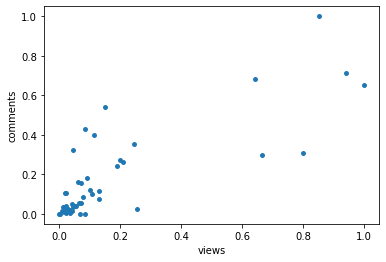

In [33]:
df = pd.DataFrame(new_df, columns = ['views','comment_count'])
df = df.iloc[:,[0,1]].values
plt.scatter(df[:,0], df[:,1],s=15)
plt.xlabel("views")
plt.ylabel("comments")

In [34]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

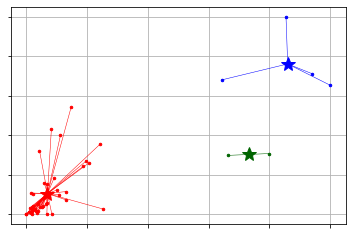

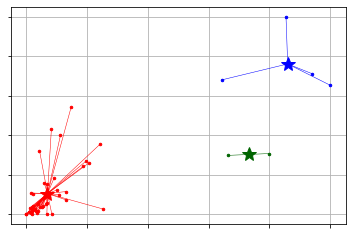

In [35]:
initial_centers = kmeans_plusplus_initializer(df, 3).initialize()
# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(df, initial_centers)
k=kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()
# Visualize obtained results
kmeans_visualizer.show_clusters(df, clusters, final_centers)